# Visualização dos dados de filmes tratados na camada Silver
---

Visualização inicial dos dados do app Letterboxd a partir do banco de dados do lakehouse. O objetivo é visualizar os parâmetros do analytics inicial e verificar como ficaram os dados tratados no ETL bronze para silver.

Para isso será usada a biblioteca python de visualização de dados seaborn assim como no analytics da camada bronze.

## Leitura do banco de dados

### Import das bibliotecas

In [13]:
import pandas as pd
from sqlalchemy import create_engine

import os
import seaborn as sns
import matplotlib.pyplot as plt

# Pandas configs
pd.set_option('display.max_colwidth', None)

DB_CONFIG = {
    "db_user": os.environ.get("DB_USER") or "postgres",
    "db_password": os.environ.get("DB_PASSWORD") or "secret",
    "db_name": os.environ.get("DB_NAME") or "postgres",
    "db_host": os.environ.get("DB_HOST") or "localhost",
    "db_port": os.environ.get("DB_PORT") or "5432"
}

### Ingestão dos dados para o pandas dataframe

In [14]:
engine = create_engine(f"postgresql+psycopg2://{DB_CONFIG["db_user"]}:{DB_CONFIG["db_password"]}@{DB_CONFIG["db_host"]}:{DB_CONFIG["db_port"]}/{DB_CONFIG["db_name"]}")

# Read full table
df = pd.read_sql("SELECT * FROM film_lakehouse", engine)

print(df.head())

       id                 title  vote_average  vote_count    status  \
0   27205             Inception         8.364       34495  Released   
1  157336          Interstellar         8.417       32571  Released   
2     155       The Dark Knight         8.512       30619  Released   
3   16869  Inglourious Basterds         8.215       20746  Released   
4     272         Batman Begins         7.701       19561  Released   

  release_date     revenue  runtime  adult     budget original_language  \
0   2010-07-15   825532764      148  False  160000000                en   
1   2014-11-05   701729206      169  False  165000000                en   
2   2008-07-16  1004558444      152  False  185000000                en   
3   2009-08-19   321457747      153  False   70000000                en   
4   2005-06-10   374218673      140  False  150000000                en   

         original_title  \
0             Inception   
1          Interstellar   
2       The Dark Knight   
3  Inglourious

### Análise exploratória

Após a leitura do csv de origem dos dados, e ingestão para a dataframe do pandas, serão gerados abaixo diversas visualizações para os dados, com a finalidade de possibilitar uma análise exploratória que será a base para o tratamento dos dados na transferência para a camada silver.

A biblioteca utilizada foi o seaborn, e algumas das visualizações escolhidas foram:

- Barplot
- Regplot
- Histograma
- lineplot
- countplot
- scatterplot

#### Visualização de campos vazios, NaN ou Null

Campos vazios, nulos ou NaN por coluna no dataset de filmes.

/tmp/ipykernel_2074587/1988179427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nulls.values, y=nulls.index, palette='viridis')


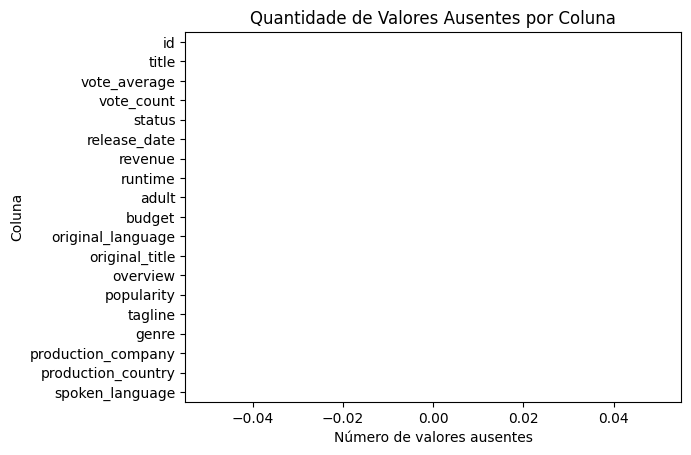

In [15]:
nulls = df.isnull().sum().sort_values(ascending=False)
sns.barplot(x=nulls.values, y=nulls.index, palette='viridis')
plt.title('Quantidade de Valores Ausentes por Coluna')
plt.xlabel('Número de valores ausentes')
plt.ylabel('Coluna')
plt.show()


#### Verificação de dados duplicados nas colunas

Contagem de dados duplicados por coluna. Importante ressaltar que dados duplicados em uma coluna não necessáriamente são um problema. 

> É **importante** notar que, apesar de o campo ID ser o identificador único do filme na base de origem e no data warehouse (camada Gold), no lakehouse (camada silver) é perfeitamente normal que ele se repita, devido à explosão das colunas compostas em linhas realizada durante o **ETL Bronze to Silver**.

/tmp/ipykernel_2074587/2660276118.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='duplicated_count', y='col', data=dup_df, palette='viridis')


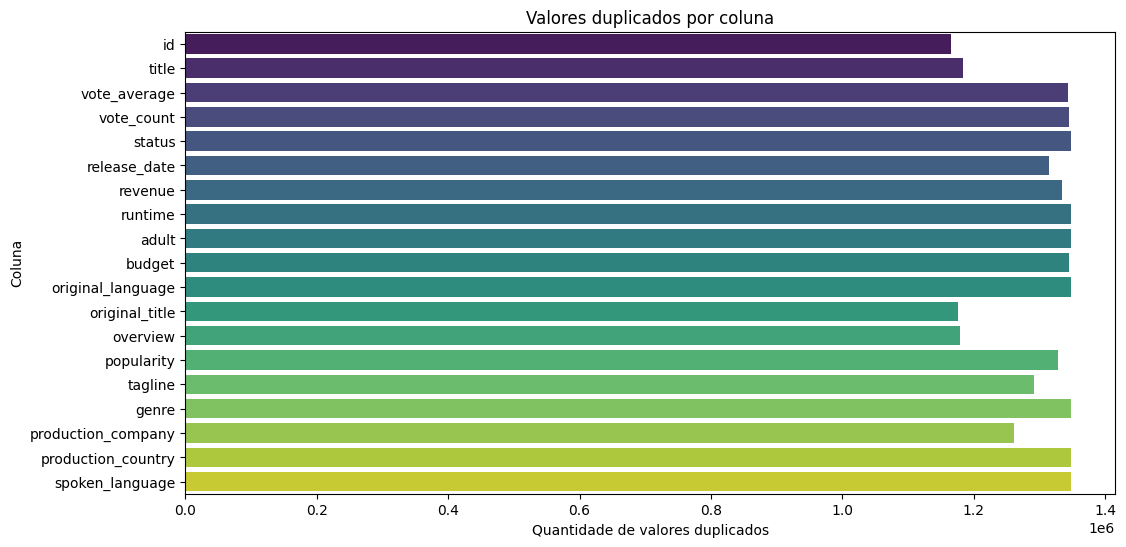

In [16]:
duplicated_counts = df.apply(lambda col: col.duplicated().sum())

dup_df = duplicated_counts.reset_index()
dup_df.columns = ['col', 'duplicated_count']

plt.figure(figsize=(12,6))
sns.barplot(x='duplicated_count', y='col', data=dup_df, palette='viridis')
plt.xlabel("Quantidade de valores duplicados")
plt.ylabel("Coluna")
plt.title("Valores duplicados por coluna")
plt.show()

#### Distribuição geral de notas de avaliação

Visualização de notas de filmes (min: 0 e max: 10) no eixo x, pela quantidade de avaliações no eixo y. 

Text(0.5, 1.0, 'Distribuição das notas de avaliação')

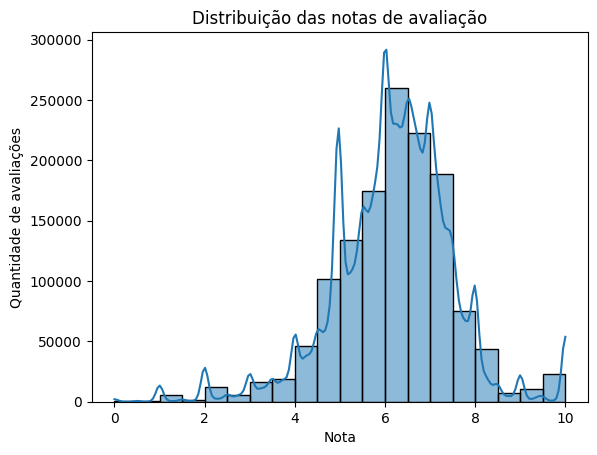

In [17]:
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.xlabel("Nota")
plt.ylabel("Quantidade de avaliações")
plt.title("Distribuição das notas de avaliação")

#### Relação entre popularidade do filme e nota de avaliação

Regressão linear de popularidade por nota de avaliação dos filmes. É possível identificar outliers com avaliações baixas e popularidade muito alta.

A coluna de média de avaliação consiste em valores entre 0 e 10, portanto o limite de 11 será adicionado ao eixo y. Foram deixados dados "fora da curva", ou seja, com popularidade altíssima, já que são filmes válidos que realmente fogem á regra, por exemplo "Barbie (2023)"

(0.0, 11.0)

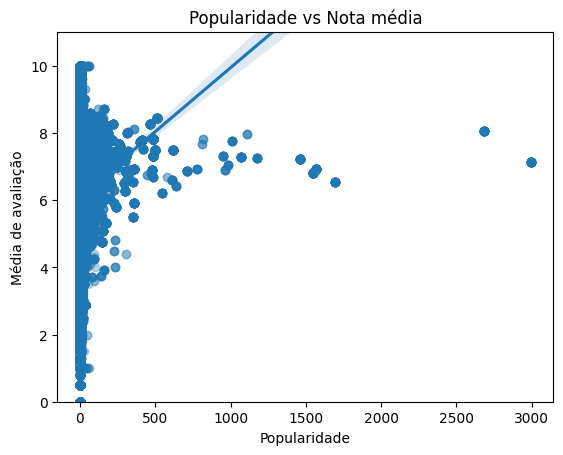

In [18]:
sns.regplot(data=df, x="popularity", y="vote_average", order=1, scatter_kws={"alpha": 0.3})
plt.title("Popularidade vs Nota média")
plt.xlabel("Popularidade")
plt.ylabel("Média de avaliação")
plt.ylim(0, 11)

In [19]:
print(df[(df["popularity"] > 400) & (df["vote_count"] == 0) & (df["vote_average"] < 1)][["title", "vote_average", "popularity"]].sort_values(by="popularity", ascending=False))

Empty DataFrame
Columns: [title, vote_average, popularity]
Index: []


#### Quantidade de filmes classificados como "Adulto"

Entendimento da quantidade de filmes adultos no dataset, para serem removidos no tratamento de dados para a camada silver.

/tmp/ipykernel_2074587/2142783712.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="adult_label", palette="Set2")


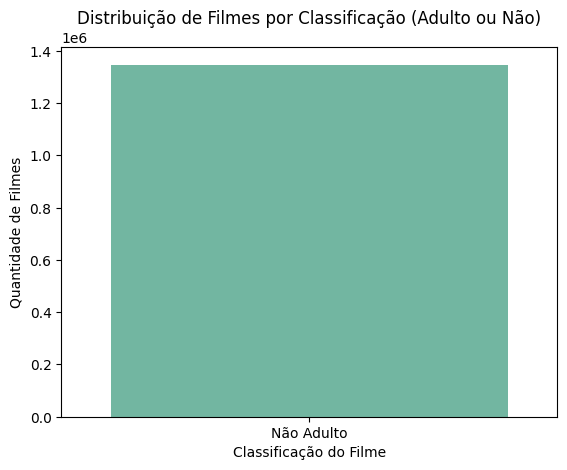

In [20]:
df["adult_label"] = df["adult"].map({True: "Adulto", False: "Não Adulto"})

sns.color_palette("mako", as_cmap=True)
sns.countplot(data=df, x="adult_label", palette="Set2")

plt.xlabel("Classificação do Filme")
plt.ylabel("Quantidade de Filmes")
plt.title("Distribuição de Filmes por Classificação (Adulto ou Não)")
plt.show()



#### Relação entre orçamento de filmes e receita Scatterplot

Correlação entre a orçamento dedicado ao filme e a receita arrecadada, visualizada em um scatterplot para entendimento da distribuição.

Text(0, 0.5, 'Receita')

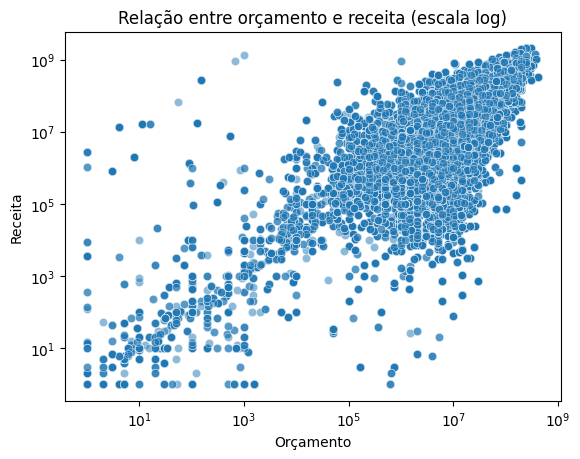

In [21]:
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.title("Relação entre orçamento e receita (escala log)")
plt.xlabel("Orçamento")
plt.ylabel("Receita")


#### Relação entre orçamento de filmes e receita com Regressão Linear

Correlação entre a orçamento dedicado ao filme e a receita arrecadada, visualizada em um gráfico de regressão linear para melhor entendimento dos outliers.

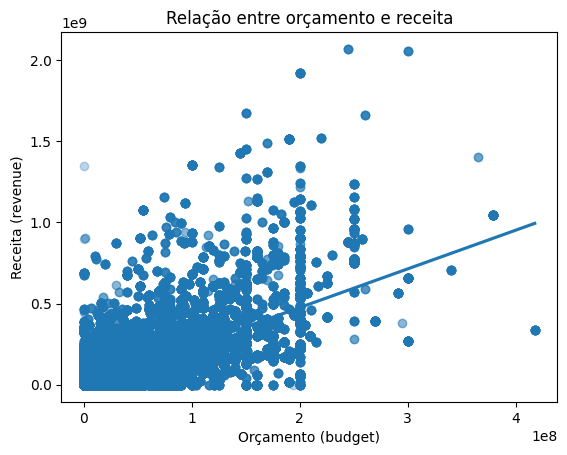

In [22]:
sns.regplot(data=df, x="budget", y="revenue", order=1, scatter_kws={"alpha": 0.3})

plt.title("Relação entre orçamento e receita")
plt.xlabel("Orçamento (budget)")
plt.ylabel("Receita (revenue)")
plt.show()

#### Distribuição dos idiomas mais comuns

Visualização dos 10 idiomas mais comuns em filmes

Text(0, 0.5, 'Idioma Original')

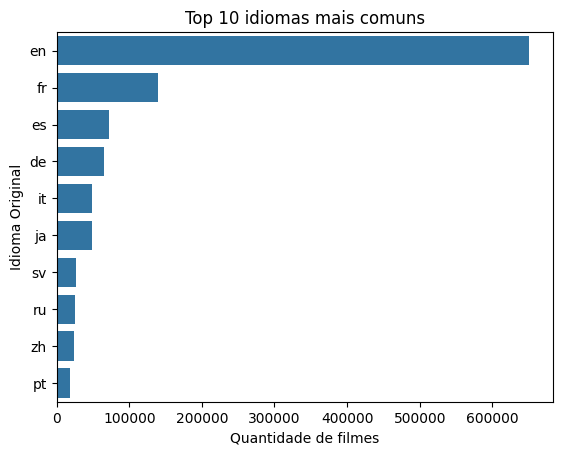

In [23]:
sns.countplot(y='original_language', data=df, order=df['original_language'].value_counts().index[:10])
plt.title("Top 10 idiomas mais comuns")
plt.xlabel("Quantidade de filmes")
plt.ylabel("Idioma Original")


#### Distribuição de filmes pelo ano de lançamento

Entendimento dos filmes por ano de lançamento

In [24]:
df["release_year"] = df["release_date"].dt.year
# print(df["release_year"])
sns.lineplot(data=df, x='release_year', y=df.groupby('release_year').size())
plt.title("Número de filmes lançados por ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Quantidade")


AttributeError: Can only use .dt accessor with datetimelike values

#### Distribuição de receita arrecadada pela nota do filme

/tmp/ipykernel_1625531/2179392640.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='vote_average', y='revenue', palette='coolwarm')


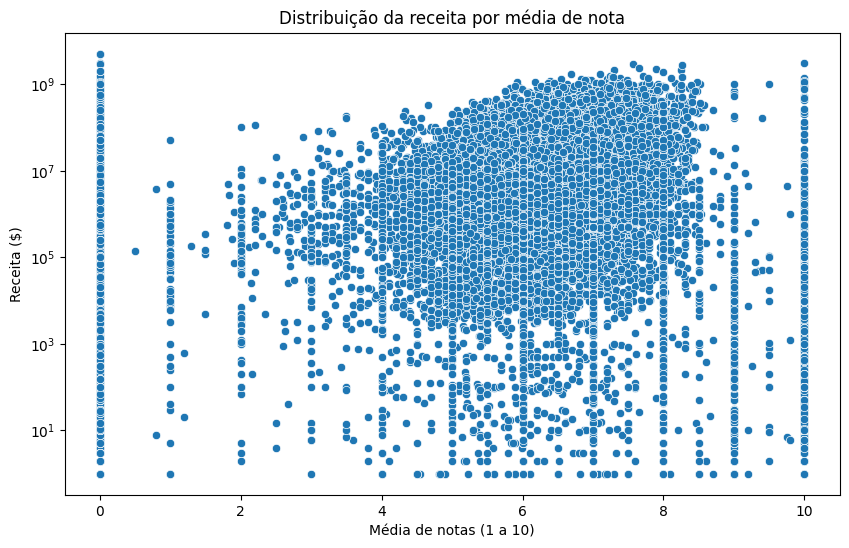

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='vote_average', y='revenue', palette='coolwarm')
plt.xlabel("Média de notas (1 a 10)")
plt.ylabel("Receita ($)")
plt.title("Distribuição da receita por média de nota")
plt.xscale('linear')
plt.yscale('log') 
plt.show()
